In [1]:
%matplotlib inline
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-rwuw2imw because the default path (/home/tsr42/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)
gray = (167/255, 168/255, 170/255, 1)
red = (179/255, 27/255, 27/255, 1)
blue = (0,47/255, 108/255,1)
markersize=20

# Mean Plots

In [3]:
datasetName = "'threeDots'" # note the single quotes to match the evaluation_results json
# combinedOutputs is the path from the root directory to the JL1-VAE models. 
# If unzipping pre-trained models you may need to change this path. 
# This path works for models trained directly with
# ./experimentScripts/train_jlonevae/train_threeDots.bash
# and evaluated with
# ./experimentScripts/evaluate_jlonevae/evaluate_threeDots.bash
# which stores models and evaluations in directories like:
# jlonevae/trainedModels/defaultConv_lone_beta4_0000_ica0_1000_lat10_batch64_lr0_0001_anneal100000/20210604-014949/representation
combinedOutputs = "trainedModels"

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Ttest_indResult(statistic=-22.14913444276251, pvalue=2.459492009375093e-05)
Ttest_indResult(statistic=-10.195530243735902, pvalue=0.0005213866312892416)
Ttest_indResult(statistic=-25.283128412342613, pvalue=1.4531559692464835e-05)
Ttest_indResult(statistic=-1.411416398523922, pvalue=0.23096218855131792)
Ttest_indResult(statistic=-0.8248208003925437, pvalue=0.4558196493888558)


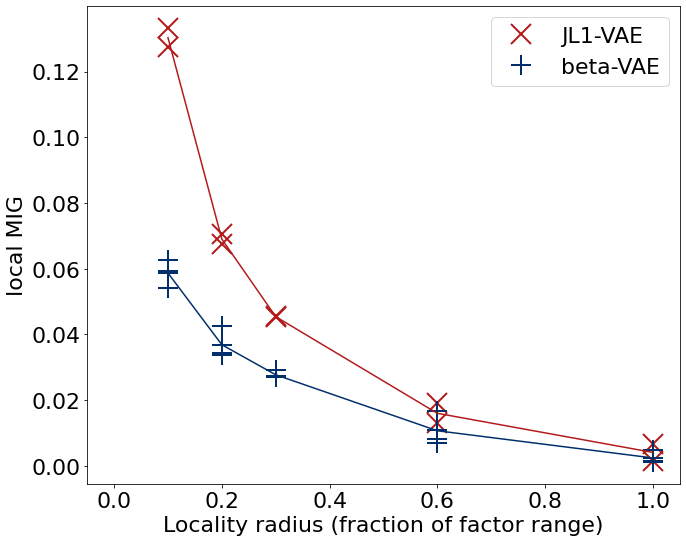

Ttest_indResult(statistic=-7.434464961429594, pvalue=0.0017478488860646474)
Ttest_indResult(statistic=-6.153496374170641, pvalue=0.003538531882216876)
Ttest_indResult(statistic=-5.607859265907957, pvalue=0.004966852390201686)
Ttest_indResult(statistic=-2.2792358227738125, pvalue=0.10701051948686002)
Ttest_indResult(statistic=-0.16334910379876802, pvalue=0.8806275855658012)


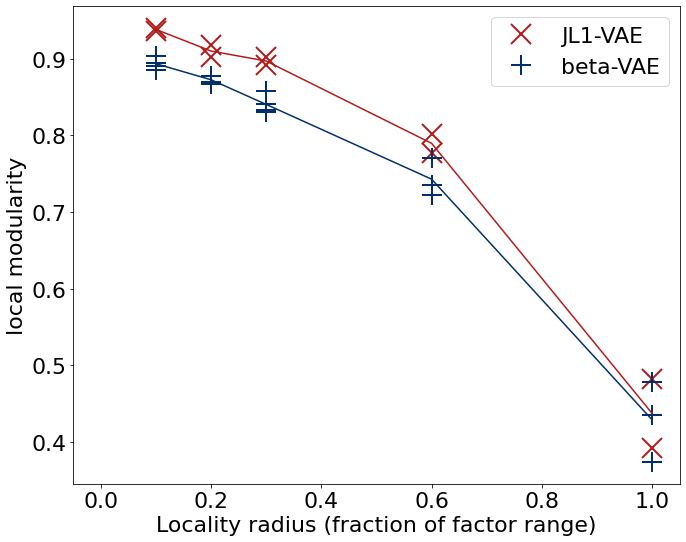

In [4]:
# Gather evaluation results
evaluation_result_template = "{}/metrics/{}/results/aggregate/evaluation.json"
experiment_output_path = f"../../{combinedOutputs}"
for metric, metvalname in [("local_mig","evaluation_results.local_discrete_migs_samples"), 
               ("local_modularity","evaluation_results.local_modularity_scores_samples")]:
    for latdim in ["10"]:
      f = plt.figure(figsize=(10,8))
      for bind, beta in enumerate(["4"]):
        experiment_names = [f"defaultConv_lone_beta{beta}_0000_ica0_1000_lat{latdim}_batch64_lr0_00??_anneal100000",
                            f"defaultConv_lone_beta{beta}_0000_ica0_0000_lat{latdim}_batch64_lr0_00??_anneal100000"
                           ]
        data = []
        for enind, experiment_name in enumerate(experiment_names):
            if enind==1:
                color=blue
                marker="+"
                label="beta-VAE"
            elif enind==0:
                color=red
                marker="x"
                label="JL1-VAE"
            evaluation_filepaths = glob.glob(f"{experiment_output_path}/{experiment_name}/*/metrics/{metric}*/results/aggregate/evaluation.json")
            for ind, filename in enumerate(evaluation_filepaths):
                #print(filename)
                evaluation_results = json.loads(
                        open(filename, "r").read())
                if evaluation_results['evaluation_config.dataset.name'] != datasetName:
                    print(f"Skipping model evaluated on {evaluation_results['evaluation_config.dataset.name']}")
                    continue
                locality = float(evaluation_results["evaluation_config.local_sample_factors.locality_proportion"])
                met_samps = evaluation_results[metvalname]
                data.append((label, locality, np.mean(met_samps)))
                if bind == 0 and ind == 0 and enind < 2:
                    plt.plot(locality, np.mean(met_samps), markerfacecolor=(1, 1, 1, 0), markeredgecolor=color, markeredgewidth=2, marker=marker,label=label, markersize=markersize,linestyle="None" )
                else:
                    plt.plot(locality, np.mean(met_samps), markerfacecolor=(1, 1, 1, 0), markeredgecolor=color, markeredgewidth=2, marker=marker, markersize=markersize,linestyle="None" )
        plt.ylabel(metric.replace("_"," ").replace("mig","MIG"))
        plt.xlabel("Locality radius (fraction of factor range)");
        plt.xlim(-0.05,1.05)

      import scipy.stats
      avgBetaMetVals = []
      avgLirjMetVals = []
      allLocalities = [0.1, 0.2, 0.3, 0.6, 1.0]
      for desiredLocality in allLocalities:
        betametvals = [metval for (label, locality, metval) in data if label == "beta-VAE" and locality == desiredLocality]
        lirjmetvals = [metval for (label, locality, metval) in data if label == "JL1-VAE" and locality == desiredLocality]
        avgBetaMetVals.append(np.mean(betametvals))
        avgLirjMetVals.append(np.mean(lirjmetvals))
        print(scipy.stats.ttest_ind(betametvals, lirjmetvals))
      plt.plot(allLocalities, avgLirjMetVals, color=red)
      plt.plot(allLocalities, avgBetaMetVals, color=blue)
      plt.legend()
      plt.tight_layout()
      f.savefig(f"threeDots_{metric}_varyingRho.png")
      plt.show();plt.close();